In [1]:
# This file is aimed to test the 2D Ising model with four body interaction terms using restricted SLMC method.

#import libraries
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from Configuration import Configuration
from Hamiltonian import first_NN_interaction, second_NN_interaction, third_NN_interaction
from LocalUpdate import LocalUpdate
from RestrictedSelfLearningUpdate import RestrictedSelfLearningUpdate
import itertools
from sklearn import linear_model
from SLMC_Training_Lib import Make_Samples_Local, Make_Samples_Restricted_SelfLearning, train_eff_Hamil, restricted_self_optimization


In [ ]:
# T > Tc, train some samples using Local Update Method, T = 5
L = 20
J = 1.
K = 0.2
T = 5
Nsamples = 3 # modified later
Nsteps = 10000 # trail number, modified later
n = 1
samples = Make_Samples_Local(L, J, K, T, Nsamples, Nsteps)
print(samples)
eff_param = train_eff_Hamil(samples, n)
print(eff_param)

In [ ]:
# T > Tc, train some samples using Local Update Method, T = 5
L = 20
J = 1.
K = 0.2
T = 5
Nsamples = 3 #modified later
Nsteps = 10000 # trail number, modified later
n = 3
samples = Make_Samples_Local(L, J, K, T, Nsamples, Nsteps)
eff_param = train_eff_Hamil(samples, n)
print(eff_param)

In [2]:
# T = Tc, use the effective Hamiltonian to get more samples, and reobtain effective Hamiltonian iteratively.
# We will get optimized effective Hamiltonian in the end.
# eff_param = [53.43157895,  1.37368421]
L  = 20
J = 1.
K = 0.2
T = 2.5
Nsamples =3 
Nsteps = 3000
restriction = 10
n = 1

# Set iteration step
Iter = 1 # modified later
print(restricted_self_optimization(Iter, L, J, K, T, Nsamples, Nsteps, eff_param, restriction))

Sample 1: 33.33 percent done.
Sample 2: 66.67 percent done.
Sample 3: 100.00 percent done.
Iteration 1, 100.00 percent done.
[9.31898734 0.90822785]


7.311576843261719
[-0.005  0.035  0.04   0.03   0.035 -0.02  -0.02   0.03   0.055  0.005
  0.005 -0.01   0.     0.     0.     0.     0.    -0.01  -0.02  -0.015
 -0.02  -0.02   0.005 -0.025 -0.045 -0.04  -0.035 -0.045 -0.04  -0.015
 -0.015 -0.015 -0.015 -0.02  -0.025 -0.03  -0.035 -0.04  -0.04  -0.03
 -0.05   0.    -0.015 -0.01  -0.01   0.02   0.015 -0.01  -0.01  -0.01
 -0.005 -0.005 -0.005 -0.01  -0.01  -0.015 -0.015 -0.01   0.015  0.015
 -0.01  -0.005 -0.02  -0.02  -0.015 -0.05  -0.045 -0.045 -0.045 -0.025
 -0.05  -0.05  -0.035  0.     0.    -0.03  -0.035 -0.015 -0.01   0.025
  0.04   0.045  0.065  0.06   0.06   0.015  0.01   0.02   0.005  0.005
  0.005  0.01  -0.035 -0.035 -0.03  -0.005 -0.01   0.015 -0.025 -0.03
 -0.03  -0.005 -0.005  0.02   0.01   0.01   0.01   0.01   0.01   0.005
  0.    -0.005 -0.01  -0.01  -0.015 -0.015  0.025  0.025  0.03   0.025
  0.025  0.02   0.02   0.02   0.02   0.025  0.025  0.02   0.02   0.02
  0.02   0.02   0.025  0.025  0.015  0.015  0.015  0.015  0.015

(-1.0, 1.0)

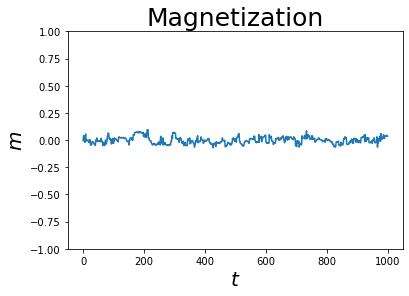

In [4]:
# Use the optimized effective Hamiltonian in retricted SLMC update

# Magnetization vs Step
L = 20
J = 1
K = 0.2
T = 2.5
restriction = 10
spins = rnd.choice([-1,1],size = (L, L))

import time
t1 = time.time()
n_cycles = 1000


mr = np.zeros(n_cycles)

# Monte Carlo
for n in range(n_cycles):
    update = RestrictedSelfLearningUpdate(spins, J, K, T, eff_param, restriction)
    spins = update.Restricted_SLMC_Update()
    config = Configuration(spins, L, J, K, T)
    mr[n] = (config.magnetization)
mr /= float(L**2)
t2 = time.time()

print(t2-t1)
print(mr)
plt.plot(mr, '-')
plt.title("Magnetization", fontsize=25)
plt.xlabel("$t$", fontsize=20)
plt.ylabel("$m$", fontsize=20)
plt.ylim(-1,1)

In [6]:
# autocorrelation fitting

L = 20
J = 1
K = 0.2
T = 2.5

nt = 300
av_m = 0.0
av_correl = np.zeros([nt])
previous_m = []

n_cycles = 10000
n_warmup = 1000

# Monte Carlo
for n in range(n_cycles + n_warmup + nt):
    
    update = RestrictedSelfLearningUpdate(spins, J, K, T, eff_param, restriction)
    spins = update.Restricted_SLMC_Update()
            
    if n >= n_warmup:
        config = Configuration(spins, L, J, K, T)
        previous_m.insert(0, config.magnetization)
        #print(previous_m)
        # get rid of furthest previous m
        if n >= n_warmup+nt:
            previous_m.pop()
            #print(previous_m)
            av_m += config.magnetization
            #print(av_m)
            for k in range(nt):
                av_correl[k] += previous_m[k] * config.magnetization
            #print(av_correl)
        
av_m  /= float(n_cycles)
av_correl /= float(n_cycles)


Autocorrelation time = 10.039523520528272


Text(0, 0.5, '$\\mathcal{C}(t)$')

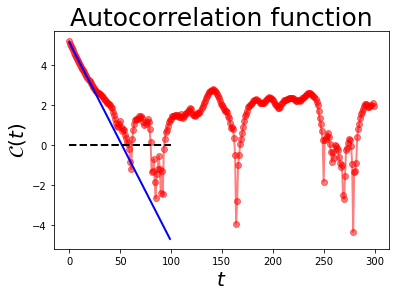

In [7]:
from scipy.optimize import curve_fit

n_fit_pts = 100
xr = np.arange(n_fit_pts, dtype=float)

# fit autocorrelation function
f = lambda x, a, b: a*np.exp(-x/float(b))
a, b = curve_fit(f, xr, (av_correl-av_m**2)[0:n_fit_pts], p0=(1000,1))[0]
print("Autocorrelation time =", b)

plt.plot(np.log(np.abs(av_correl-av_m**2)), '-ro', lw=2, alpha=0.5)

plt.plot(xr, np.log(f(xr, a, b)), 'b-', lw=2)
plt.plot([0,100], [0,0], 'k--', lw=2)

plt.title("Autocorrelation function", fontsize=25)
plt.xlabel("$t$", fontsize=20)
plt.ylabel(r"$\mathcal{C}(t)$", fontsize=20)
#plt.xlim(0, n_fit_pts+10)

T = 0.500000 and 7.14 percent done
T = 1.000000 and 14.29 percent done
T = 1.500000 and 21.43 percent done
T = 2.000000 and 28.57 percent done
T = 2.100000 and 35.71 percent done
T = 2.200000 and 42.86 percent done
T = 2.300000 and 50.00 percent done
T = 2.400000 and 57.14 percent done
T = 2.500000 and 64.29 percent done
T = 2.600000 and 71.43 percent done
T = 2.700000 and 78.57 percent done
T = 2.700000 and 85.71 percent done
T = 2.900000 and 92.86 percent done
T = 3.100000 and 100.00 percent done
time: 892


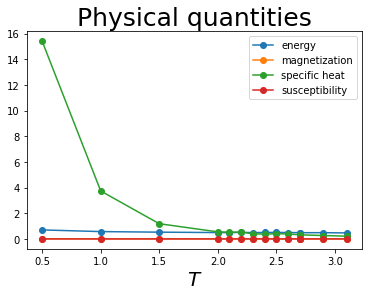

In [9]:
# Physical Quantity vs Temp

## !!! Check the result before believing it! The training is not sufficient.!!!

import time
# This is a production script, it will save the results in files
L = 20
J = 1
K = 0.2
restriction = 10
spins = rnd.choice([-1,1],size = (L, L))

# set temperature range
temp_range = np.hstack([np.arange(0.5,2.0,0.5), np.arange(2.0,2.7,0.1), np.arange(2.7,3.3,0.2)])
mag = np.zeros_like(temp_range)
energ = np.zeros_like(temp_range)
chi = np.zeros_like(temp_range)
cv = np.zeros_like(temp_range)

time1 = time.time()
# lattice size
l = [L]
for L in l:
    for i,T in enumerate(temp_range):
    
        av_m, av_m2, av_e, av_e2 = 0,0,0,0

        n_cycles = 10000
        n_warmup = 300

        # Monte Carlo
        for n in range(n_warmup+n_cycles):
            update = RestrictedSelfLearningUpdate(spins, J, K, T, eff_param, restriction)
            spins = update.Restricted_SLMC_Update()
                
            if n >= n_warmup:
                config = Configuration(spins, L, J, K, T)
                av_e  += config.energy
                av_e2 += config.energy**2
                av_m  += config.magnetization
                av_m2 += config.magnetization**2
            
        # normalize averages
        av_m  /= float(n_cycles)
        av_m2 /= float(n_cycles)
        av_e  /= float(n_cycles)
        av_e2 /= float(n_cycles)
            
        # get physical quantities
        fact = 1./L**2
        mag[i] = fact * av_m
        energ[i] = fact * av_e
        cv[i] = fact * (av_e2 - av_e**2) / T**2
        chi[i] = fact * (av_m2 - av_m**2) / T
    
        # print info because progress can be slow
        print("T = %f and %.2f percent done"%(T, (100.*(i+1))/len(temp_range)))


    # save quantities in a file
    np.savetxt("R_SLMC_update_test_energ_%i.dat"%L, energ)
    np.savetxt("R_SLMC_update_test_mag_%i.dat"%L, mag)
    np.savetxt("R_SLMC_update_test_cv_%i.dat"%L, cv)
    np.savetxt("R_SLMC_update_test_chi_%i.dat"%L, chi)
    
time2 = time.time()
print('time: %i'%(time2-time1))

for L in l:
    energ = np.loadtxt("R_SLMC_update_test_energ_%i.dat"%L)
    mag = np.loadtxt("R_SLMC_update_test_mag_%i.dat"%L)
    cv = np.loadtxt("R_SLMC_update_test_cv_%i.dat"%L)
    chi = np.loadtxt("R_SLMC_update_test_chi_%i.dat"%L)
    
    fig = plt.figure()
    plt.plot(temp_range, np.loadtxt("R_SLMC_update_test_energ_%i.dat"%L), '-o', label="energy")
    plt.plot(temp_range, np.abs(np.loadtxt("R_SLMC_update_test_mag_%i.dat"%L)), '-o', label="magnetization")
    plt.plot(temp_range, np.loadtxt("R_SLMC_update_test_cv_%i.dat"%L), '-o', label="specific heat")
    plt.plot(temp_range, np.loadtxt("R_SLMC_update_test_chi_%i.dat"%L)/1000, '-o', label="susceptibility")

#plt.plot([Tc,Tc], [0,1.6], '--', lw=3)
    plt.legend()
    plt.title("Physical quantities", fontsize=25)
    plt.xlabel("$T$", fontsize=20)
    plt.show()